# Model figures for all populations

## Import and define functions
[back to top](#Summarize-models)

In [106]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [107]:
sns.set_style("white")
plt.style.use("huddlej")

In [108]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [109]:
colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']

In [110]:
colors.reverse()

In [111]:
colors

['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

In [112]:
ncols = 2
color_by_predictor = {
    'offspring': '#000000',
    'normalized_fitness': '#000000',
    'fitness': '#000000',
    'ep': '#4575b4',
    'ep_wolf': '#4575b4',
    'ep_star': '#4575b4',
    'ep_x': '#4575b4',
    'rb': '#4575b4',
    'cTiter': '#91bfdb',
    'cTiter_x': '#91bfdb',
    'cTiterSub': '#91bfdb',
    'cTiterSub_star': '#91bfdb',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    "dms_nonepitope": "#fee090",
    "dms_entropy": "#fee090",
    'unnormalized_lbi': '#fc8d59',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "offspring": "observed fitness",
    "normalized_fitness": "true fitness",
    "fitness": "estimated fitness",
    "ep": "epitope mutations",
    "ep_wolf": "Wolf epitope mutations",
    "ep_star": "epitope ancestor",
    "ep_x": "epitope cross-immunity",
    "rb": "Koel epitope mutations",
    "cTiter": "HI tree",
    "cTiter_x": "HI tree cross-immunity",
    "cTiterSub": "linear HI mut phenotypes",
    "cTiterSub_star": "ancestral HI mut phenotypes",
    "cTiterSub_x": "HI sub cross-immunity",
    "ne_star": "non-epitope mutations",
    "dms_star": "DMS mutation effect",
    "dms_nonepitope": "DMS non-epitope",
    "dms_entropy": "DMS entropy",
    "unnormalized_lbi": "unnormalized LBI",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

predictors_to_drop = [
    #"cTiter-ne_star",
    #"delta_frequency-ne_star",
    #"lbi-ep_x-ne_star"
]

In [113]:
def get_individual_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" not in predictor and predictor != "naive"
    ]

def get_composite_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" in predictor
    ]

In [152]:
def plot_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m-%d", height=12, width=12,
                                             text_vertical_padding=0.12, hspace=0.1, wspace=0.2, max_predictor_name_length=45,
                                             share_y=True):
    # Determine bounds for given data to set axes domains and ranges.
    min_normal_error = errors_by_time_df["validation_error"].min()
    max_normal_error = errors_by_time_df["validation_error"].max()
    std_normal_error = errors_by_time_df["validation_error"].std()

    min_coefficient = coefficients_by_time_df["coefficient"].min()
    max_coefficient = coefficients_by_time_df["coefficient"].max()

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=hspace,
        wspace=wspace
    )

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()

    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])
        if len(composite_predictors_name) > max_predictor_name_length:
            predictor_name_spacing = "\n"
        else:
            predictor_name_spacing = " "

        distance_ax = plt.subplot(gs[i, 1])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel("Distance\nto future")
        distance_ax.set_ylim(-0.5, 0.8)
        
        """
        distance_ax.text(
            0.025,
            0.95,
            "model:%s%.2f +/- %.2f" % (predictor_name_spacing, error_df["validation_error"].mean(), error_df["validation_error"].std()),
            fontdict={"fontsize": 12},
            verticalalignment="top",
            transform=distance_ax.transAxes
        )
        """

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        distance_ax.plot(
            pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_error_df["validation_error"],
            "o-",
            color="#cccccc",
            zorder=-10,
            label="naive:%s%.2f +/- %.2f" % (predictor_name_spacing, naive_error_df["validation_error"].mean(), naive_error_df["validation_error"].std())
        )

        distance_ax.plot(
            pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
            error_df["validation_error"],
            "o-",
            color="#000000",
            label="model:%s%.2f +/- %.2f" % (predictor_name_spacing, error_df["validation_error"].mean(), error_df["validation_error"].std())
        )

        distance_ax.set_xlim(min_date, max_date)
        
        distance_ax.set_ylim(min_normal_error, max_normal_error + 2.0 * std_normal_error)
        #distance_ax.set_ylim(0, max_normal_error + std_normal_error / 2)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)
        distance_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=10
        )

        coefficient_ax = plt.subplot(gs[i, 0])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        
        if share_y:
            coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 2)

        """
        offset = 0.9
        for individual_predictor, individual_predictor_df in coefficient_df.groupby("predictor"):            
            coefficient_ax.text(
                0.035,
                offset,
                "%s: %.2f +/- %.2f" % (
                    name_by_predictor[individual_predictor],
                    individual_predictor_df["coefficient"].mean(),
                    individual_predictor_df["coefficient"].std()
                ),
                fontdict={"fontsize": 12},
                transform=coefficient_ax.transAxes
            )
            offset = offset - text_vertical_padding
        """

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )
        
        for predictor, predictor_coefficient_df in coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )

        coefficient_ax.set_xlim(min_date, max_date)
        
        coefficient_ax.tick_params(axis='x', which='major', labelsize=12, pad=0)
        coefficient_ax.tick_params(axis='x', which='minor', pad=0)
        
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter(date_fmt_string)
        coefficient_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=10
        )

    fig.autofmt_xdate(rotation=rotation, ha="center")
    gs.tight_layout(fig, h_pad=hspace)
    # show x-axis tick lines
    
    return (fig, axes, gs)

In [115]:
"""fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(natural_errors_by_time_df)[:1],
    height=3,
    rotation=33
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")"""

'fig, axes, gs = plot_accuracy_and_coefficients_for_build(\n    natural_errors_by_time_df,\n    natural_coefficients_by_time_df,\n    get_composite_predictors_for_data_frame(natural_errors_by_time_df)[:1],\n    height=3,\n    rotation=33\n)\n#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")'

In [116]:
"""fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep_x", "cTiter_x", "ne_star", "lbi"],
    height=9
)
plt.savefig("../manuscript/figures/model-accuracy-by-timepoint-for-h3n2.png")"""

'fig, axes, gs = plot_accuracy_and_coefficients_for_build(\n    natural_errors_by_time_df,\n    natural_coefficients_by_time_df,\n    ["ep_x", "cTiter_x", "ne_star", "lbi"],\n    height=9\n)\nplt.savefig("../manuscript/figures/model-accuracy-by-timepoint-for-h3n2.png")'

## Load data

In [117]:
simulated_sample = "simulated_sample_3"
natural_sample = "natural_sample_0_with_90_vpm_sliding"
luksza_sample = "luksza_lassig"

In [118]:
errors_file = "../results/distance_model_errors.tsv"
coefficients_file = "../results/distance_model_coefficients.tsv"

In [119]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])

In [120]:
errors_by_time_df["sample"].unique()

array(['simulated_sample_3'], dtype=object)

In [121]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])
errors_by_time_df = errors_by_time_df[~errors_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == simulated_sample].copy()
natural_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == natural_sample].copy()
luksza_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == luksza_sample].copy()

In [122]:
simulated_errors_by_time_df.shape

(198, 6)

In [123]:
natural_errors_by_time_df.shape

(0, 6)

In [124]:
luksza_errors_by_time_df.shape

(0, 6)

In [125]:
coefficients_by_time_df = pd.read_csv(coefficients_file, sep="\t", parse_dates=["validation_timepoint"])
coefficients_by_time_df = coefficients_by_time_df[~coefficients_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == simulated_sample].copy()
natural_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == natural_sample].copy()
luksza_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == luksza_sample].copy()

In [126]:
simulated_coefficients_by_time_df.shape

(198, 6)

In [127]:
natural_coefficients_by_time_df.shape

(0, 6)

In [128]:
luksza_coefficients_by_time_df.shape

(0, 6)

In [129]:
get_individual_predictors_for_data_frame(simulated_errors_by_time_df)

['normalized_fitness', 'ep_x', 'ne_star', 'lbi', 'delta_frequency']

In [130]:
get_individual_predictors_for_data_frame(natural_errors_by_time_df)

[]

## Distance to the future

### Simulated populations

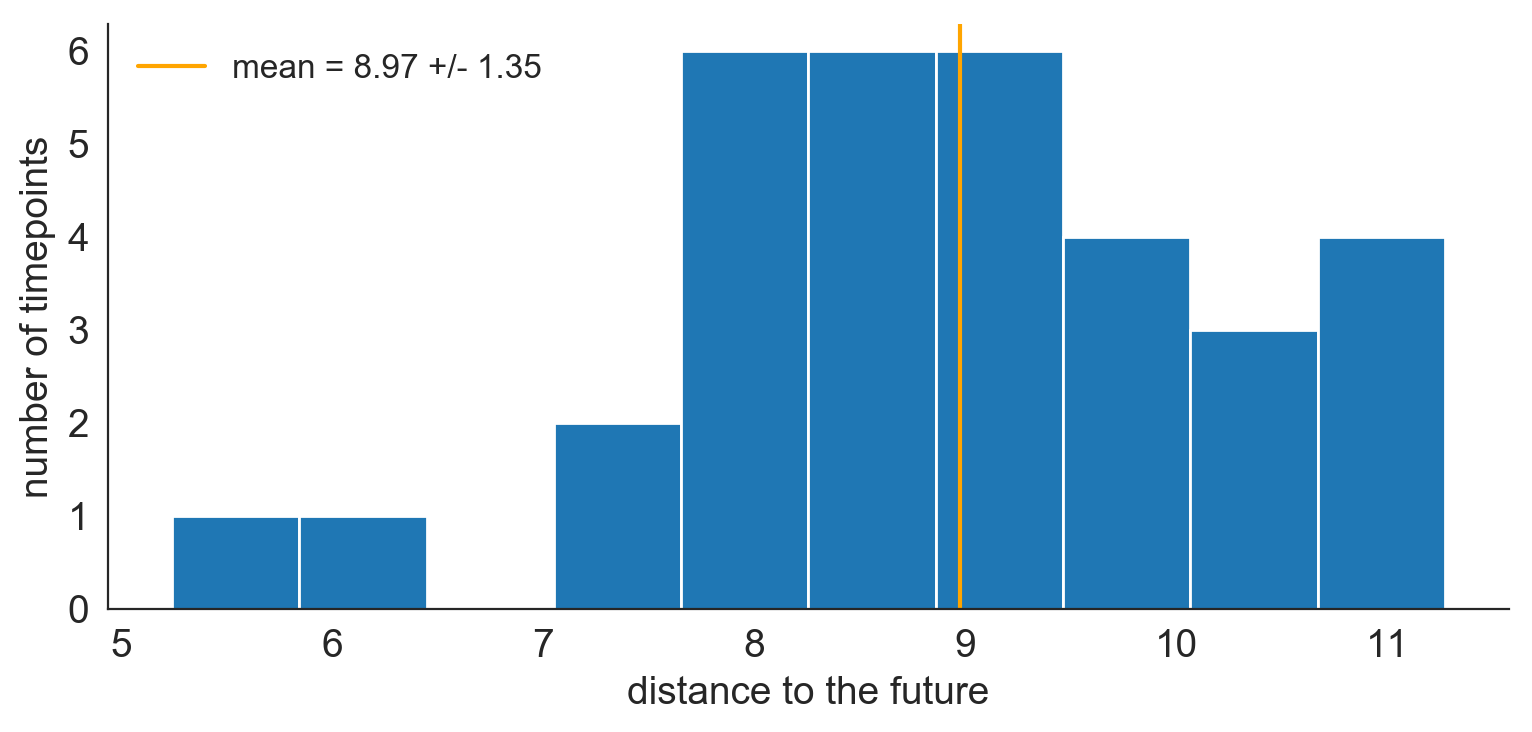

In [163]:
naive_simulated_errors_by_time_df = simulated_errors_by_time_df[simulated_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(naive_simulated_errors_by_time_df, bins=10, label=None)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_simulated_errors_by_time_df.mean()
std_y = naive_simulated_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange",
    label="mean = %.2f +/- %.2f" % (mean_y, std_y)
)
ax.legend(
    frameon=False
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-simulated-populations-between-timepoints.png")

### Natural populations

In [ ]:
naive_natural_errors_by_time_df = natural_errors_by_time_df[natural_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_natural_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_natural_errors_by_time_df.mean()
std_y = naive_natural_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
#plt.savefig("../manuscript/figures/distance-of-natural-populations-between-timepoints.png")

### Luksza and Lassig populations

In [ ]:
naive_luksza_errors_by_time_df = luksza_errors_by_time_df[luksza_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_luksza_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_luksza_errors_by_time_df.mean()
std_y = naive_luksza_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-luksza-lassig-populations-between-timepoints.png")

## Figure 2: Summary of models for simulated populations

In [132]:
simulated_errors_by_time_df["model"] = simulated_errors_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)

In [133]:
naive_simulated_errors_by_time_df = simulated_errors_by_time_df.query("predictors == 'naive'").copy()

In [134]:
naive_simulated_errors_by_time_df.head()

,predictors,validation_error,validation_n,validation_timepoint,type,sample,model
0,naive,8.870808,630,2023-10-01,simulated,simulated_sample_3,naive
1,naive,8.351673,630,2024-04-01,simulated,simulated_sample_3,naive
2,naive,10.027961,630,2024-10-01,simulated,simulated_sample_3,naive
3,naive,11.031343,630,2025-04-01,simulated,simulated_sample_3,naive
4,naive,8.814196,630,2025-10-01,simulated,simulated_sample_3,naive


In [135]:
simulated_errors_by_time_df = simulated_errors_by_time_df.merge(
    naive_simulated_errors_by_time_df,
    on=["sample", "type", "validation_timepoint", "validation_n"],
    suffixes=["", "_naive"]
)

In [136]:
simulated_errors_by_time_df.head()

,predictors,validation_error,validation_n,validation_timepoint,type,sample,model,predictors_naive,validation_error_naive,model_naive
0,naive,8.870808,630,2023-10-01,simulated,simulated_sample_3,naive,naive,8.870808,naive
1,normalized_fitness,7.427476,630,2023-10-01,simulated,simulated_sample_3,true fitness,naive,8.870808,naive
2,ep_x,8.893666,630,2023-10-01,simulated,simulated_sample_3,epitope cross-immunity,naive,8.870808,naive
3,ne_star,7.452196,630,2023-10-01,simulated,simulated_sample_3,non-epitope mutations,naive,8.870808,naive
4,lbi,9.502722,630,2023-10-01,simulated,simulated_sample_3,LBI,naive,8.870808,naive


In [137]:
simulated_errors_by_time_df["model_minus_naive"] = (
    simulated_errors_by_time_df["validation_error"] - simulated_errors_by_time_df["validation_error_naive"]
)

In [138]:
simulated_errors_by_time_df["model_better_than_naive"] = (simulated_errors_by_time_df["model_minus_naive"] < 0)

In [139]:
simulated_errors_by_time_df["relative_improvement"] = (
    simulated_errors_by_time_df["validation_error"] / simulated_errors_by_time_df["validation_error_naive"]
) - 1.0

In [140]:
simulated_errors_by_time_df.head()

,predictors,validation_error,validation_n,validation_timepoint,type,sample,model,predictors_naive,validation_error_naive,model_naive,model_minus_naive,model_better_than_naive,relative_improvement
0,naive,8.870808,630,2023-10-01,simulated,simulated_sample_3,naive,naive,8.870808,naive,0.000000,False,0.000000
1,normalized_fitness,7.427476,630,2023-10-01,simulated,simulated_sample_3,true fitness,naive,8.870808,naive,-1.443331,True,-0.162706
2,ep_x,8.893666,630,2023-10-01,simulated,simulated_sample_3,epitope cross-immunity,naive,8.870808,naive,0.022859,False,0.002577
3,ne_star,7.452196,630,2023-10-01,simulated,simulated_sample_3,non-epitope mutations,naive,8.870808,naive,-1.418612,True,-0.159919
4,lbi,9.502722,630,2023-10-01,simulated,simulated_sample_3,LBI,naive,8.870808,naive,0.631914,False,0.071235


In [141]:
simulated_model_selection = simulated_errors_by_time_df.groupby("model").aggregate({
    "model_minus_naive": ["mean"],
    "model_better_than_naive": ["sum", "mean"]
}).sort_values(("model_minus_naive", "mean"))

In [142]:
simulated_model_selection.loc[:, ("model_better_than_naive", "sum")] = simulated_model_selection[("model_better_than_naive", "sum")].astype(int)

In [143]:
simulated_model_selection

model_minus_naive model_better_than_naive          
                                    mean                     sum      mean
model                                                                     
true fitness                   -2.166182                      32  0.969697
LBI                            -1.411100                      29  0.878788
delta frequency                -0.851867                      26  0.787879
non-epitope mutations          -0.713624                      29  0.878788
naive                           0.000000                       0  0.000000
epitope cross-immunity          0.031517                      14  0.424242

In [144]:
simulated_model_selection_table = simulated_model_selection.to_latex(
    float_format="%.2f"
)

In [145]:
with open("../manuscript/tables/simulated_model_selection.tex", "w") as oh:
    oh.write(simulated_model_selection_table)

In [164]:
simulated_errors_by_time_df.head(1)

,predictors,validation_error,validation_n,validation_timepoint,type,sample,model,predictors_naive,validation_error_naive,model_naive,model_minus_naive,model_better_than_naive,relative_improvement
0,naive,8.870808,630,2023-10-01,simulated,simulated_sample_3,naive,naive,8.870808,naive,0.0,False,0.0


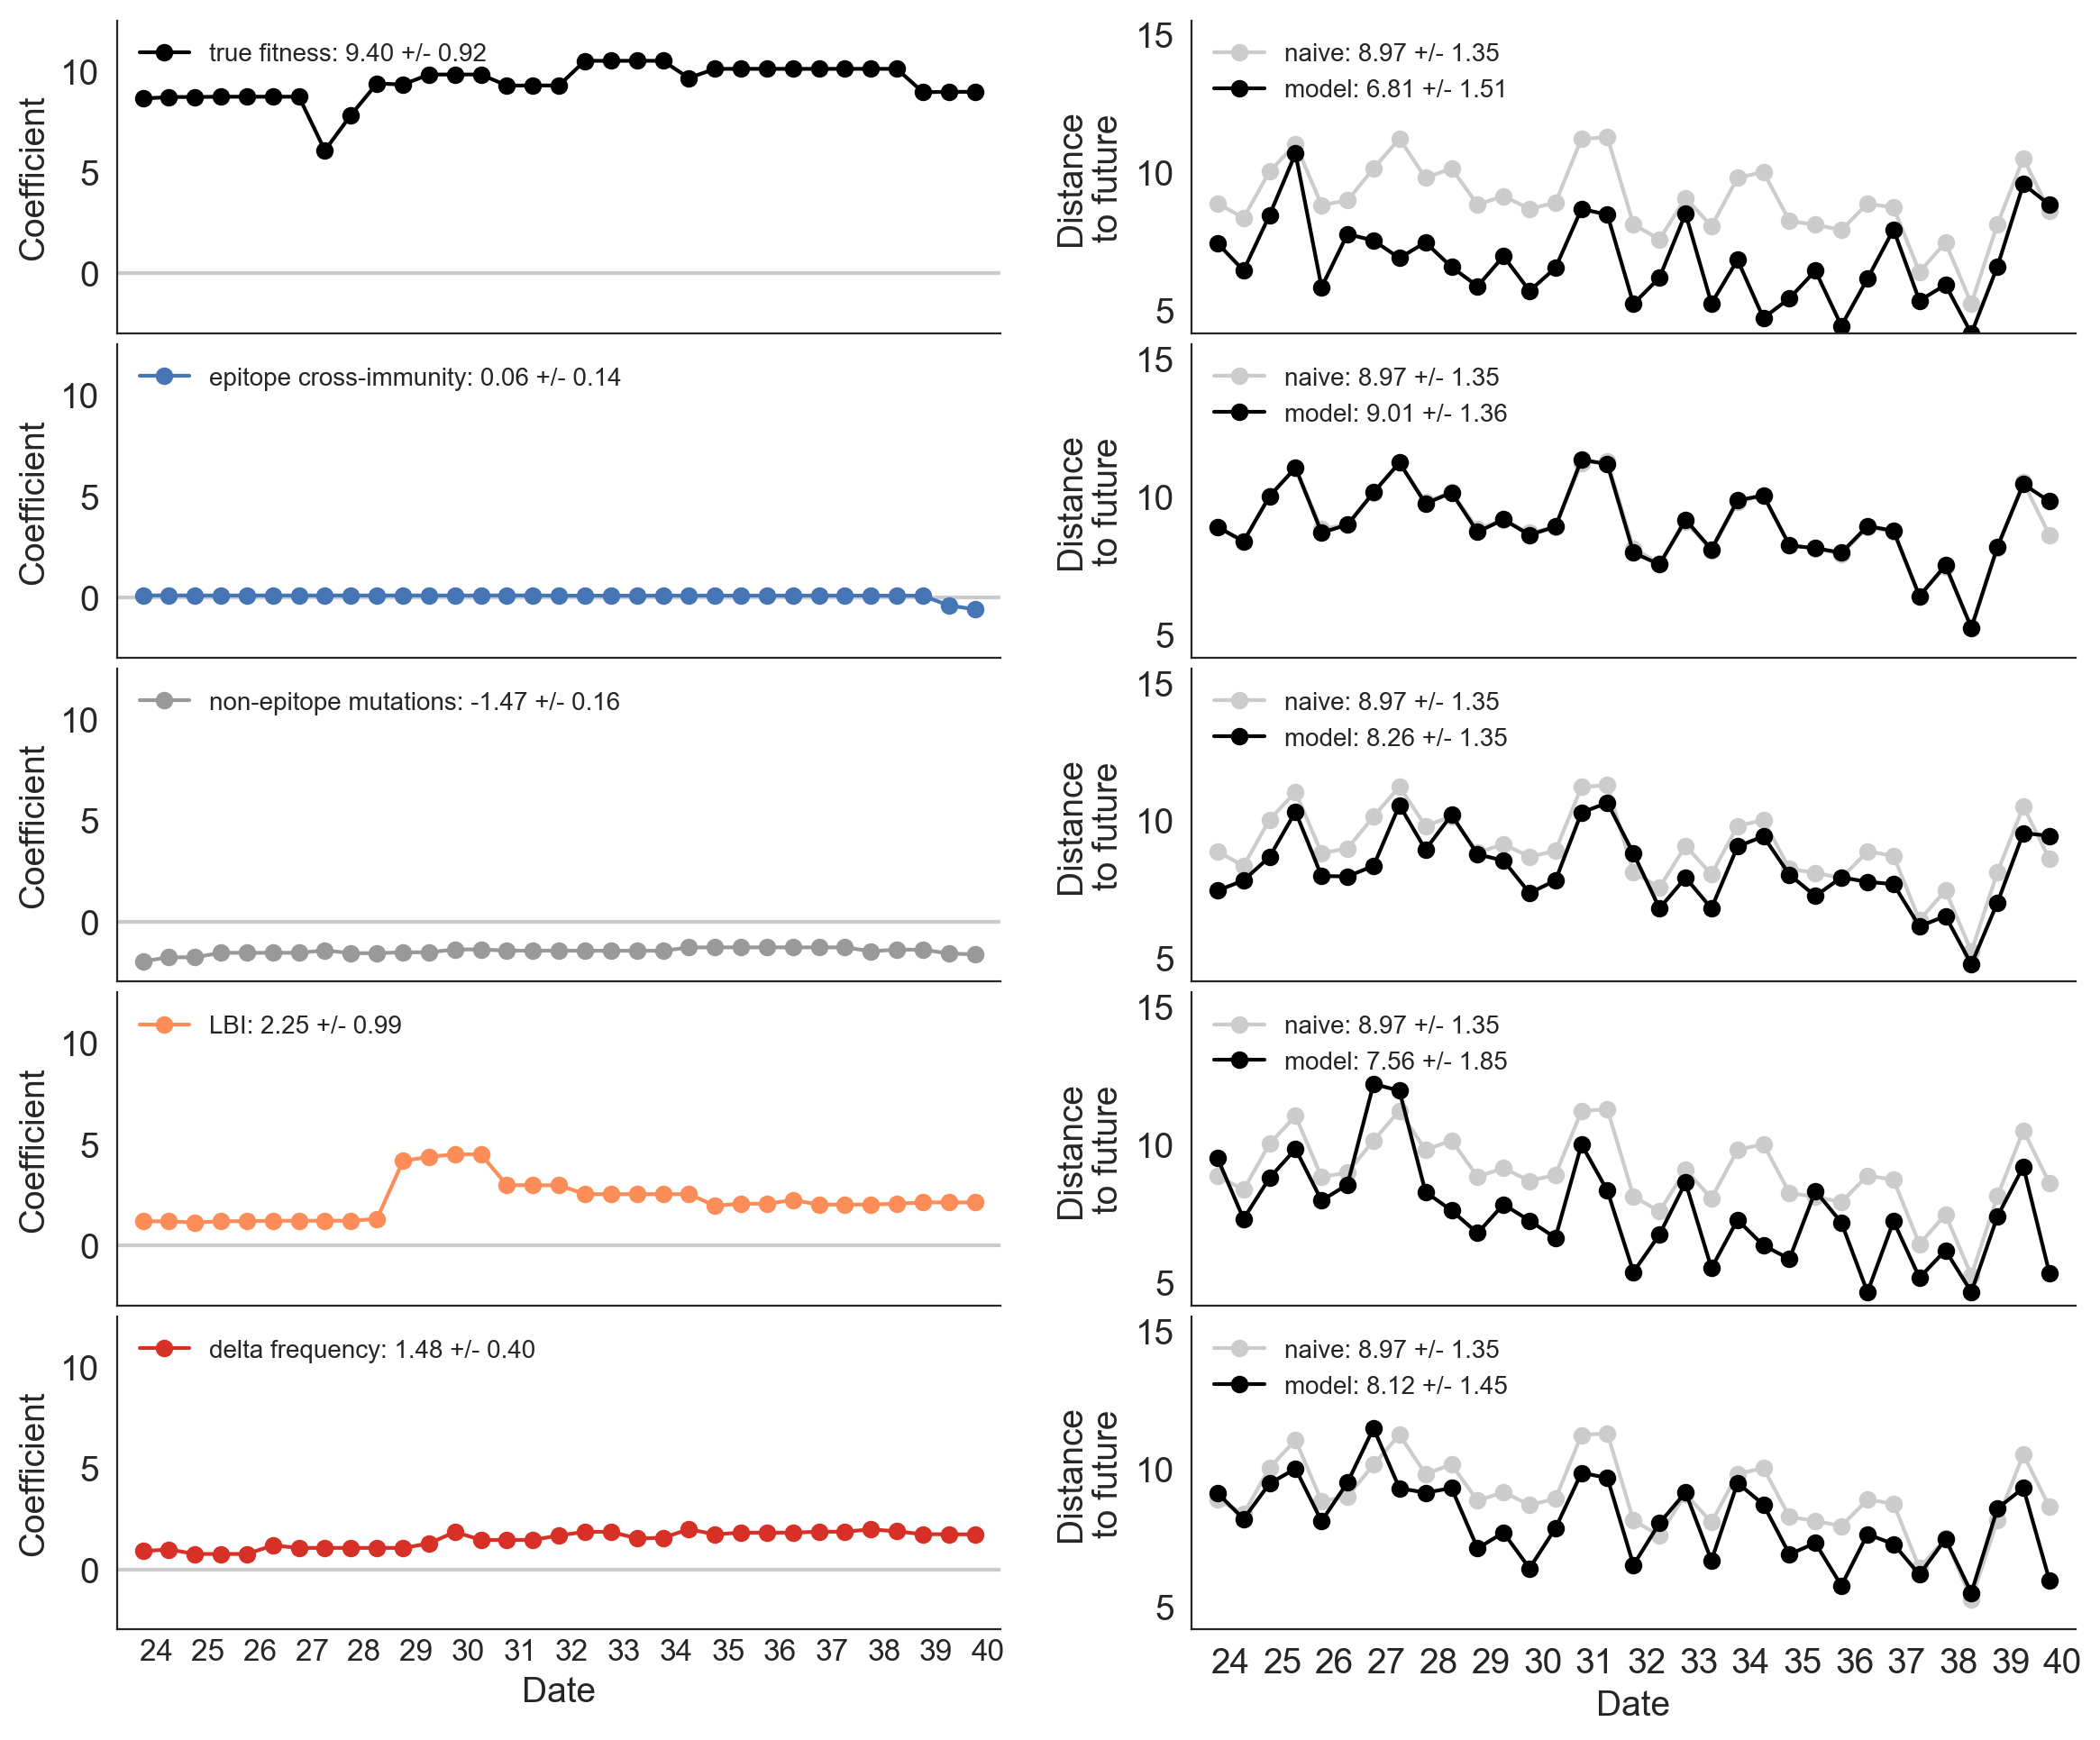

In [154]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=10,
    hspace=0.1,
    share_y=True
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-simulated-populations.png")

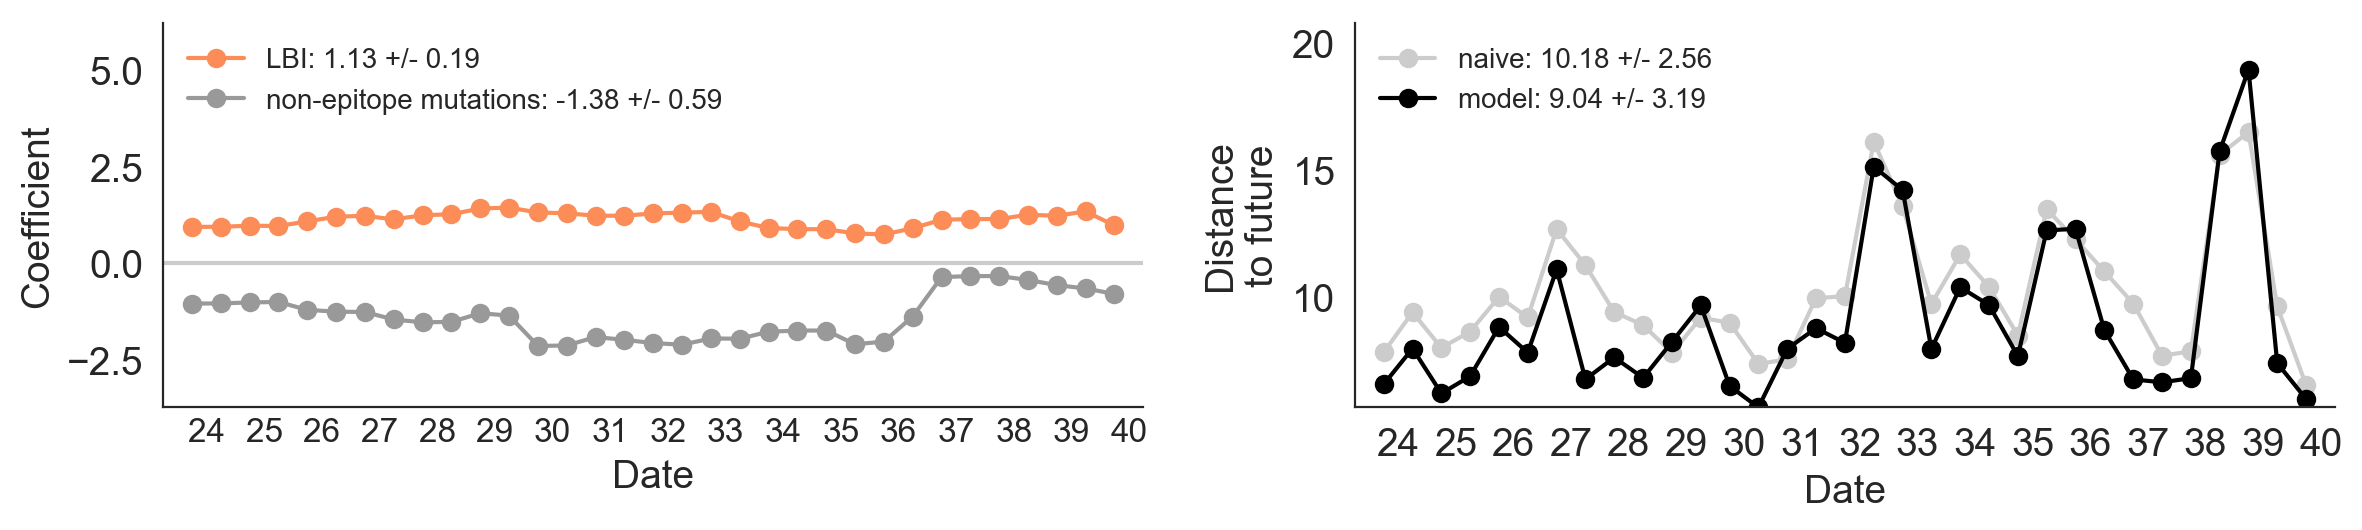

In [105]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=3
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-simulated-populations.png")

## Figure 3: Summary of models for natural populations

In [ ]:
natural_errors_by_time_df.tail()

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(natural_errors_by_time_df),
    height=20
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations-all-individual-predictors.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(natural_errors_by_time_df),
    height=20
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")

### Individual models

In [ ]:
subset_of_individual_predictors = [
    "ep_x",
    "cTiter_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    subset_of_individual_predictors,
    height=8
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

In [ ]:
cross_immunity_better_than_naive = (natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "ep_x", "validation_error"
].values < natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "naive", "validation_error"
].values).sum()
cross_immunity_better_than_naive

In [ ]:
titers_better_than_naive = (natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "cTiter_x", "validation_error"
].values < natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "naive", "validation_error"
].values).sum()
titers_better_than_naive

In [ ]:
total_timepoints = natural_errors_by_time_df.loc[natural_errors_by_time_df["predictors"] == "cTiter_x", "validation_error"].values.shape[0]

In [ ]:
total_timepoints

In [ ]:
titers_better_than_naive / float(total_timepoints)

In [ ]:
cross_immunity_better_than_naive / float(total_timepoints)

### Within category model comparisons

#### Antigenic

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep", "ep_x", "ep_wolf", "rb"],
    height=8
)
plt.savefig("../manuscript/figures/unadjusted-epitope-model-accuracy-and-coefficients-for-natural-populations.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["cTiter", "cTiter_x", "cTiterSub", "cTiterSub_x"],
    height=8
)
plt.savefig("../manuscript/figures/unadjusted-HI-model-accuracy-and-coefficients-for-natural-populations.png")

#### Functional

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["dms_star", "dms_entropy", "dms_nonepitope", "ne_star"],
    height=6
)
plt.savefig("../manuscript/figures/unadjusted-DMS-model-accuracy-and-coefficients-for-natural-populations.png")

#### All categories

In [ ]:
within_category_composite_predictors = [
    "ep_x-cTiter_x",
    "ne_star-dms_star",
    "lbi-delta_frequency"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    within_category_composite_predictors,
    height=6,
    text_vertical_padding=0.15
)
plt.savefig("../manuscript/figures/within-category-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Best two-metric composite models

In [ ]:
best_two_metric_model = [
    "cTiter_x-ne_star",
    "lbi-ne_star",
    "delta_frequency-ne_star"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    best_two_metric_model,
    height=6,
    text_vertical_padding=0.12
)
#plt.savefig("../manuscript/figures/best-two-metric-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Best three-metric composite models

In [ ]:
best_three_metric_model = [
    "lbi-cTiter_x-ne_star",
    "delta_frequency-cTiter_x-ne_star"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    best_three_metric_model,
    height=5
)
#plt.savefig("../manuscript/figures/best-three-metric-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

In [ ]:
naive_error_df.head()

In [ ]:
naive_error_df.tail()

Calculate sum of differences between the estimated distances from the naive model and each biological model. The higher sum per model, the more the biological model outperforms the naive model.

In [ ]:
naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

In [ ]:
natural_errors_by_time_with_naive_df = natural_errors_by_time_df.merge(
    naive_error_df,
    on=["validation_timepoint", "validation_n", "type", "sample"],
    suffixes=["_model", "_naive"]
)

In [ ]:
natural_errors_by_time_with_naive_df["model_gain"] = (
    natural_errors_by_time_with_naive_df["validation_error_naive"] - natural_errors_by_time_with_naive_df["validation_error_model"]
)

In [ ]:
natural_errors_by_time_with_naive_df.head()

In [ ]:
natural_errors_by_time_with_naive_df.groupby("predictors_model")["model_gain"].sum().sort_values(ascending=False)

## Figure 4: Summary of models for Luksza and Lassig populations

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(luksza_errors_by_time_df),
    height=6
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    ["lbi", "ep_x", "ne_star"] + get_composite_predictors_for_data_frame(luksza_errors_by_time_df)
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")